# Projeto ADC

##### Imports

In [1]:
import networkx as nx
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

#### Function to load the graph

In [2]:
def load_graph_from_edgelist(filepath):
    G = nx.Graph()
    
    with open(filepath, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            
            try:
                parts = list(map(int, line.strip().split()))
                
                if len(parts) > 1:
                    for to_node in parts[1:]:
                        G.add_edge(parts[0], to_node)
            except ValueError:
                continue
    
    return G

#### Function to load the communities

In [3]:
def load_communities(filepath):
    communities = defaultdict(list)
    
    with open(filepath, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            
            try:
                parts = list(map(int, line.strip().split()))
                
                if len(parts) > 1:
                    community_id = parts[0]
                    nodes = parts[1:]
                    
                    for node in nodes:
                        communities[node].append(community_id)
            except ValueError:
                continue
    
    return communities

In [4]:
# Paths to your files
graph_filepath = 'com-youtube.ungraph.txt'
community_filepath = 'com-youtube.all.cmty.txt'

# Load graph
# Load graph
G = load_graph_from_edgelist(graph_filepath)

# Load communities
node_communities = load_communities(community_filepath)

# Add community information to the graph
nx.set_node_attributes(G, {node: {'communities': comms} for node, comms in node_communities.items()}, 'communities')

# Print some basic information
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Number of nodes with community info: {len(node_communities)}")

Number of nodes: 1134890
Number of edges: 2987624
Number of nodes with community info: 48907


In [50]:
import networkx as nx
from collections import defaultdict
import random
import pickle

def load_graph_from_edgelist(filepath):
    G = nx.Graph()
    
    with open(filepath, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            
            try:
                parts = list(map(int, line.strip().split()))
                
                if len(parts) > 1:
                    for to_node in parts[1:]:
                        G.add_edge(parts[0], to_node)
            except ValueError:
                continue
    
    return G

def load_communities(filepath):
    communities = defaultdict(list)
    
    with open(filepath, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            
            try:
                parts = list(map(int, line.strip().split()))
                
                if len(parts) > 1:
                    community_id = parts[0]
                    nodes = parts[1:]
                    
                    for node in nodes:
                        communities[community_id].append(node)
            except ValueError:
                continue
    
    return communities

graph_filepath = 'com-youtube.ungraph.txt'
community_filepath = 'com-youtube.all.cmty.txt'

G = load_graph_from_edgelist(graph_filepath)
communities = load_communities(community_filepath)

# remover nos duplicados nas comunidades (o ficheiro de comunidades tem nos repetidos)
def remove_comm_dupes(communities):
    community_nodes = defaultdict(set)
    for community, nodes in communities.items():
        community_nodes[community] = set(nodes)
    return community_nodes

communities = remove_comm_dupes(communities)

# Ordenar as comunidades pelo tamanho
sorted_communities = sorted(communities.items(), key=lambda x: len(x[1]))

# Definir limites para escolher comunidades
MIN_NODES = 10
MAX_NODES = 20000

selected_nodes = set()
for community_id, nodes in sorted_communities:
    if MIN_NODES <= len(nodes) <= MAX_NODES:
        selected_nodes.update(nodes)
    if len(selected_nodes) >= MAX_NODES:
        break

subgraph = G.subgraph(selected_nodes).copy()

print(f"Número de nós no subgrafo inicial: {subgraph.number_of_nodes()}")
print(f"Número de arestas no subgrafo inicial: {subgraph.number_of_edges()}")

if subgraph.number_of_nodes() > 0 and subgraph.number_of_edges() > 0:
    nx.write_edgelist(subgraph, 'subgraph.edgelist')
else:
    print("Nenhum subgrafo válido foi gerado. Verifique os parâmetros ou os dados.")

# Calcular métricas do subgrafo
subgraph_acc = nx.average_clustering(subgraph)
subgraph_degree_assortativity = nx.degree_assortativity_coefficient(subgraph)
subgraph_average_degree = sum(dict(subgraph.degree()).values()) / subgraph.number_of_nodes()
subgraph_density = nx.density(subgraph)
subgraph_diameter = nx.diameter(subgraph) if nx.is_connected(subgraph) else 'Subgrafo não conectado'

# Imprimir as métricas
print("Métricas do subgrafo inicial:")
print(f"  - Average Clustering Coefficient: {subgraph_acc}")
print(f"  - Degree Assortativity Coefficient: {subgraph_degree_assortativity}")
print(f"  - Average Degree: {subgraph_average_degree}")
print(f"  - Density: {subgraph_density}")
print(f"  - Diameter: {subgraph_diameter}")

subgraph_nodes = set(selected_nodes)  # Inicialmente contém os nós das comunidades selecionadas

# 2. Aplicar PageRank-based Sampling para selecionar nós importantes
def pagerank_sampling(graph, num_nodes=40000):
    pagerank_scores = nx.pagerank(graph)
    sorted_nodes = sorted(pagerank_scores, key=pagerank_scores.get, reverse=True)
    return set(sorted_nodes[:num_nodes])

pagerank_nodes = pagerank_sampling(G, num_nodes=15000)
subgraph_nodes.update(pagerank_nodes)
print(f"Número de nós após PageRank Sampling: {len(subgraph_nodes)}")

# 3. Aplicar Snowball Sampling para expandir conexões entre comunidades
def snowball_sampling(graph, start_node, depth=2, max_nodes=30000):
    sampled_nodes = set([start_node])
    frontier = [start_node]
    
    while frontier and len(sampled_nodes) < max_nodes:
        new_frontier = []
        for node in frontier:
            neighbors = list(graph.neighbors(node))
            new_frontier.extend(neighbors)
            sampled_nodes.update(neighbors)
            if len(sampled_nodes) >= max_nodes:
                break
        frontier = new_frontier
    
    return sampled_nodes

# Selecionar nós na borda do subgrafo para iniciar Snowball Sampling
boundary_nodes = [node for node in subgraph_nodes if len(set(G.neighbors(node)) - subgraph_nodes) > 0]
selected_boundary_nodes = random.sample(boundary_nodes, min(10, len(boundary_nodes)))
snowball_nodes = set()
for node in selected_boundary_nodes:
    snowball_nodes.update(snowball_sampling(G, node, depth=2, max_nodes=100))

# Adicionar nós do Snowball Sampling ao subgrafo
subgraph_nodes.update(snowball_nodes)
print(f"Número de nós após Snowball Sampling: {len(subgraph_nodes)}")

# 4. Aplicar BFS para garantir que a componente seja conectada
def bfs_sampling(graph, start_node, max_nodes=50000):
    visited = set([start_node])
    queue = [start_node]
    
    while queue and len(visited) < max_nodes:
        node = queue.pop(0)
        neighbors = list(graph.neighbors(node))
        for neighbor in neighbors:
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(neighbor)
                if len(visited) >= max_nodes:
                    break
    
    return visited

bfs_start_node = random.choice(list(subgraph_nodes))
bfs_nodes = bfs_sampling(G, bfs_start_node, max_nodes=15000)
subgraph_nodes.update(bfs_nodes)
print(f"Número de nós após BFS Sampling: {len(subgraph_nodes)}")

# 5. Aplicar Random Walk Sampling para garantir diversidade
def random_walk_sampling(graph, start_node, steps=200):
    sampled_nodes = set()
    current_node = start_node
    
    for _ in range(steps):
        neighbors = list(graph.neighbors(current_node))
        if neighbors:
            next_node = random.choice(neighbors)
            sampled_nodes.add(next_node)
            current_node = next_node
        else:
            break
    
    return sampled_nodes

initial_nodes = random.sample(list(subgraph_nodes), min(5, len(subgraph_nodes)))
random_walk_nodes = set()
for node in initial_nodes:
    random_walk_nodes.update(random_walk_sampling(G, node, steps=500))

subgraph_nodes.update(random_walk_nodes)
print(f"Número de nós após Random Walk Sampling: {len(subgraph_nodes)}")

# Criar um subgrafo a partir dos nós coletados
final_subgraph = G.subgraph(subgraph_nodes).copy()

print(f"Número de nós no subgrafo final: {final_subgraph.number_of_nodes()}")
print(f"Número de arestas no subgrafo final: {final_subgraph.number_of_edges()}")

# Calcular métricas do subgrafo final
final_subgraph_acc = nx.average_clustering(final_subgraph)
final_subgraph_degree_assortativity = nx.degree_assortativity_coefficient(final_subgraph)
final_subgraph_average_degree = sum(dict(final_subgraph.degree()).values()) / final_subgraph.number_of_nodes()
final_subgraph_density = nx.density(final_subgraph)
final_subgraph_diameter = nx.diameter(final_subgraph) if nx.is_connected(final_subgraph) else 'Subgrafo não conectado'

print("Métricas do subgrafo final:")
print(f"  - Average Clustering Coefficient: {final_subgraph_acc}")
print(f"  - Degree Assortativity Coefficient: {final_subgraph_degree_assortativity}")
print(f"  - Average Degree: {final_subgraph_average_degree}")
print(f"  - Density: {final_subgraph_density}")
print(f"  - Diameter: {final_subgraph_diameter}")

# Salvar variáveis importantes usando pickle
with open('saved_data.pkl', 'wb') as f:
    pickle.dump({
        'G': G,
        'subgraph': subgraph,
        'final_subgraph': final_subgraph,
        'communities': communities,
        'sorted_communities': sorted_communities,
        'selected_nodes': selected_nodes,
        'subgraph_nodes': subgraph_nodes
    }, f)

print("Variáveis importantes foram salvas com sucesso usando pickle.")

Número de nós no subgrafo inicial: 20127
Número de arestas no subgrafo inicial: 118778
Métricas do subgrafo inicial:
  - Average Clustering Coefficient: 0.20858203820135346
  - Degree Assortativity Coefficient: 0.028105419427307935
  - Average Degree: 11.802851890495354
  - Density: 0.0005864479722992822
  - Diameter: Subgrafo não conectado
Número de nós após PageRank Sampling: 32369
Número de nós após Snowball Sampling: 67694
Número de nós após BFS Sampling: 67697
Número de nós após Random Walk Sampling: 68706
Número de nós no subgrafo final: 68706
Número de arestas no subgrafo final: 702240
Métricas do subgrafo final:
  - Average Clustering Coefficient: 0.27007731013763997
  - Degree Assortativity Coefficient: -0.04637017665025698
  - Average Degree: 20.441882804995195
  - Density: 0.0002975312248743934
  - Diameter: Subgrafo não conectado
Variáveis importantes foram salvas com sucesso usando pickle.


#### Subsetting

Top 1000 largest communities with at least 3 nodes

In [52]:
######## Outro bloco de código para carregar as variáveis e o subgrafo ########
import pickle
import networkx as nx

# Carregar o subgrafo, as comunidades e a lista de nós salvos
with open('saved_data.pkl', 'rb') as f:
    saved_data = pickle.load(f)
    
final_subgraph = saved_data['final_subgraph']
communities = saved_data['communities']
subgraph_nodes = saved_data['subgraph_nodes']
G = saved_data['G']

# Verificar o subgrafo carregado
print(f"Número de nós no subgrafo carregado: {final_subgraph.number_of_nodes()}")
print(f"Número de arestas no subgrafo carregado: {final_subgraph.number_of_edges()}")


Número de nós no subgrafo carregado: 68706
Número de arestas no subgrafo carregado: 702240


#### Visualize subset

##### Create .gml file to load in Gephi

Added the 'community' field so we can color nodes by community in Gephi.

In [53]:
# map communities
node_to_community = {}
for comm_id, nodes in communities.items():
    for node in nodes:
        node_to_community[node] = comm_id

# add community attribute
for node in final_subgraph.nodes():
    final_subgraph.nodes[node]['community'] = node_to_community.get(node, -1)

# export to gml
nx.write_gml(final_subgraph, "graph_with_communities.gml")


##### Show the PNG exported from Gephi

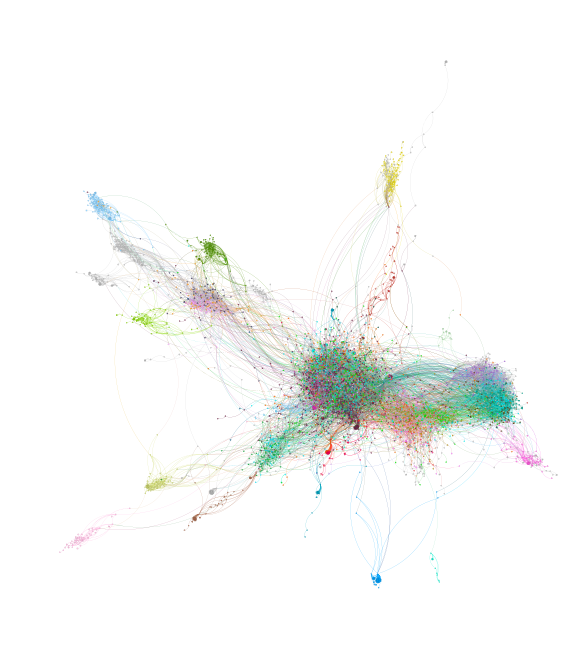

In [74]:
from IPython.display import Image, display

image_path = "graph_with_communities.png"

display(Image(filename=image_path))


#### Compute community metrics for subset

In [63]:
import networkx as nx

def compute_community_metrics(G, communities):
    metrics = []

    for (comm_number, community_nodes) in communities.items():  
        subgraph = G.subgraph(community_nodes)
        
        # ver se a comunidade é composta por nós isolados
        num_edges = subgraph.number_of_edges()
        
        if num_edges == 0:
            clustering = 0  
            density = 0     
            internal_edge_fraction = 0  
        else:
            # métricas
            clustering = nx.average_clustering(subgraph)
            density = nx.density(subgraph)
            internal_edges = num_edges
            total_edges = sum([G.degree(node) for node in community_nodes if node in G])
            internal_edge_fraction = internal_edges / total_edges if total_edges > 0 else 0
        
        metrics.append({
            "community_id": comm_number,
            "num_nodes": len(community_nodes),
            "clustering": clustering,
            "density": density,
            "internal_edge_fraction": internal_edge_fraction
        })

    return metrics

community_metrics = compute_community_metrics(final_subgraph, communities)


#### Compare results to full network

In [64]:
# compute cc and density for communities in the subgraph
subset_community_clustering = sum([m["clustering"] for m in community_metrics]) / len(community_metrics)
subset_community_density = sum([m["density"] for m in community_metrics]) / len(community_metrics)

# full network metrics (found at SNAP website)
full_clustering = 0.0808
full_density = nx.density(G)

print("Comparison of Metrics:")
print(f"Full Network Clustering Coefficient: {full_clustering}")
print(f"Subset Community Clustering Coefficient: {subset_community_clustering}")
print(f"Full Network Density: {full_density}")
print(f"Subset Community Density: {subset_community_density}")

Comparison of Metrics:
Full Network Clustering Coefficient: 0.0808
Subset Community Clustering Coefficient: 0.04207870848723552
Full Network Density: 4.639260713241579e-06
Subset Community Density: 0.09255819825150617


#### Visualize results
comunidades maiores -> menos coesas e menos densas <br>
comunidades menores -> mais coesas e mais densas <br>
isto sugere que comunidades maiores estão mais 'espalhadas' e têm conexões mais escassas provavelmente devido a serem mais diversas e ao facto de haver diferentes niveis de engagement dentro da comunidade

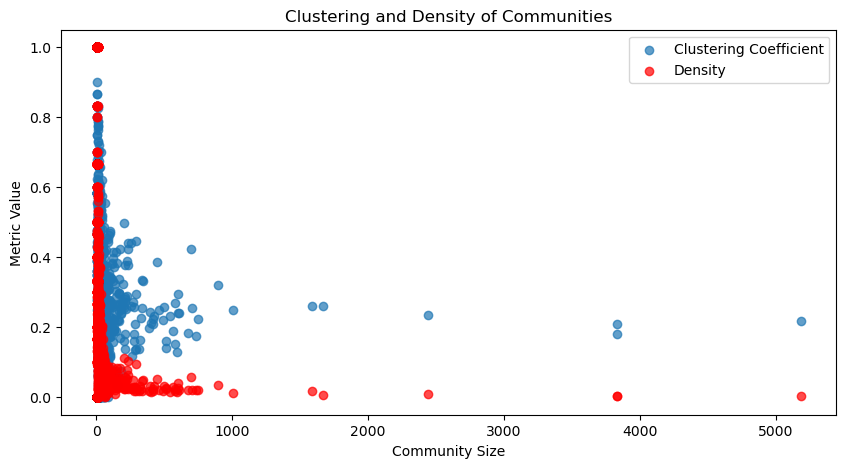

In [65]:
df = pd.DataFrame(community_metrics)


plt.figure(figsize=(10, 5))
plt.scatter(df["num_nodes"], df["clustering"], label="Clustering Coefficient", alpha=0.7)
plt.scatter(df["num_nodes"], df["density"], label="Density", alpha=0.7, color="red")
plt.xlabel("Community Size")
plt.ylabel("Metric Value")
plt.title("Clustering and Density of Communities")
plt.legend()
plt.show()


#### Measure influence of each node on the subgraph

In [66]:
def compute_node_influence(G, communities):
    flat_comms = [node for nodes in communities.values() for node in nodes]
    nodes_in_communities = list(set(flat_comms).intersection(list(G.nodes())))
    subgraph = G.subgraph(nodes_in_communities)

    # compute centrality metrics
    degree_centrality = nx.degree_centrality(subgraph)
    # k=500 to reduce computation time due to large amount of edges
    betweenness_centrality = nx.betweenness_centrality(subgraph, k=500, seed=42) 


    return degree_centrality, betweenness_centrality

degree_centrality, betweenness_centrality = compute_node_influence(final_subgraph, communities)

In [67]:
avg_degree_centrality = sum(degree_centrality.values()) / len(degree_centrality)
avg_betweenness_centrality = sum(betweenness_centrality.values()) / len(betweenness_centrality)

print("Average Degree Centrality: ", avg_degree_centrality)
print("Average Betweenness Centrality: ", avg_betweenness_centrality)

Average Degree Centrality:  0.0005977393921619358
Average Betweenness Centrality:  0.00010758098485787739


##### Visualization

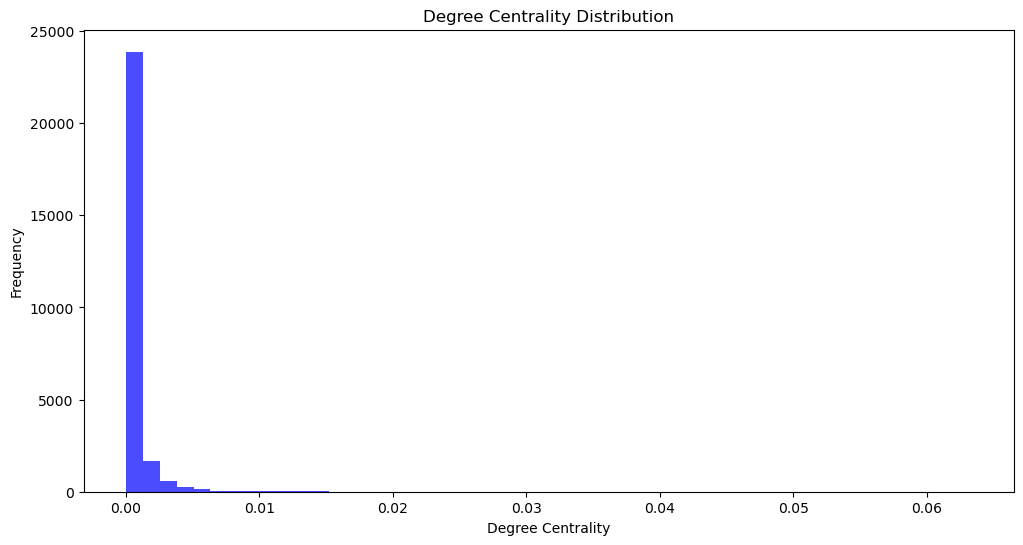

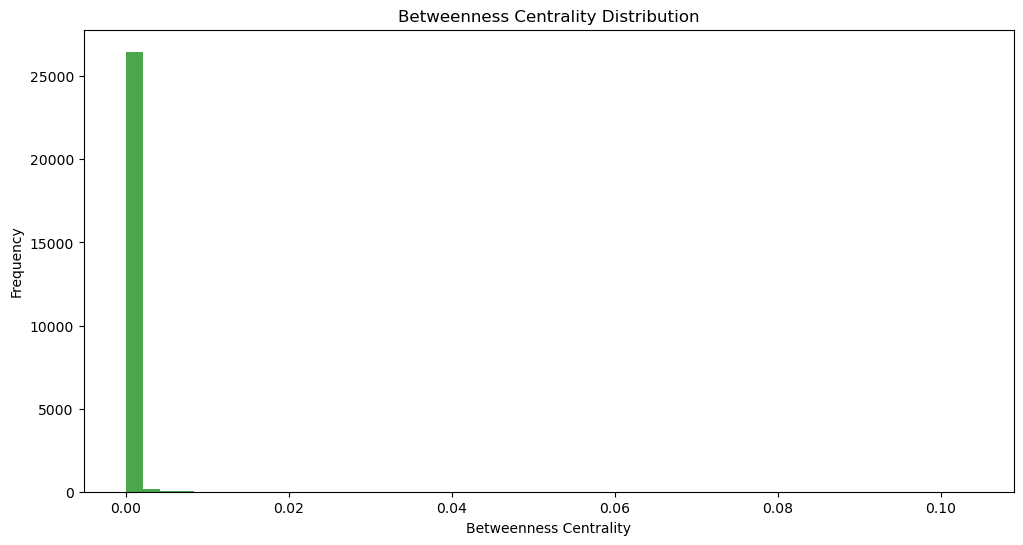

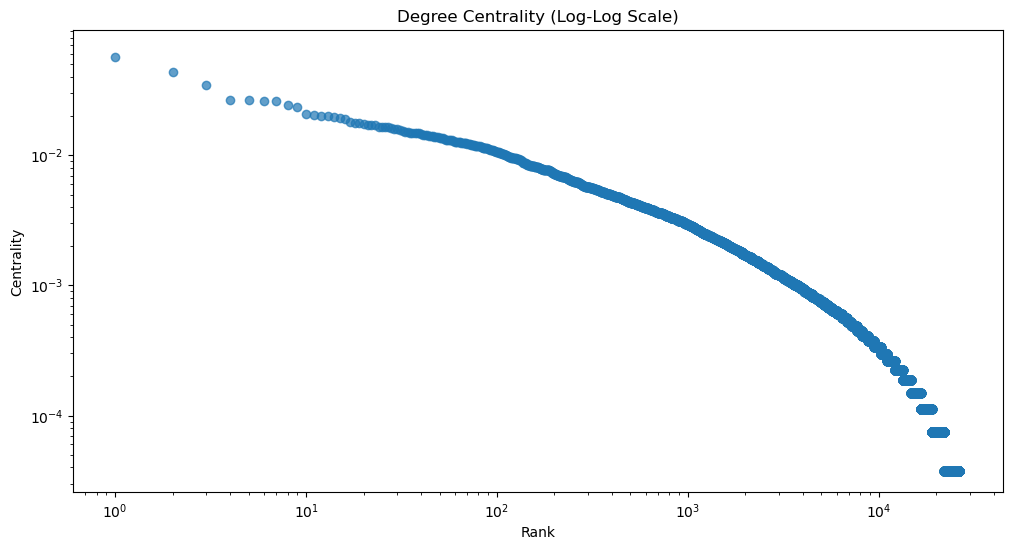

In [68]:
# degree centrality distribution
plt.figure(figsize=(12, 6))
plt.hist(list(degree_centrality.values()), bins=50, color='blue', alpha=0.7)
plt.title("Degree Centrality Distribution")
plt.xlabel("Degree Centrality")
plt.ylabel("Frequency")
plt.show()

# betweenness centrality distribution
plt.figure(figsize=(12, 6))
plt.hist(list(betweenness_centrality.values()), bins=50, color='green', alpha=0.7)
plt.title("Betweenness Centrality Distribution")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Frequency")
plt.show()

# log-log degree centrality 
plt.figure(figsize=(12, 6))
degree_values = sorted(degree_centrality.values(), reverse=True)
plt.plot(range(len(degree_values)), degree_values, marker="o", linestyle="none", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.title("Degree Centrality (Log-Log Scale)")
plt.xlabel("Rank")
plt.ylabel("Centrality")
plt.show()

#### Measure influential nodes within communities

In [69]:
import numpy as np

# avg centrality per community
def avg_community_centrality(communities, centrality):
    community_scores = defaultdict(list)
    for comm_id, nodes in communities.items():
        for node in nodes:
            if node in centrality:
                community_scores[comm_id].append(centrality[node])
    
    community_avg_scores = {comm_id: np.mean(scores) for comm_id, scores in community_scores.items() if scores}
    return community_avg_scores


avg_degree_centrality_by_comm = avg_community_centrality(communities, degree_centrality)
avg_betweenness_centrality_by_comm = avg_community_centrality(communities, betweenness_centrality)

# sort by avg score
top_degree_centrality_communities = sorted(avg_degree_centrality_by_comm.items(), key=lambda x: -x[1])[:10]
top_betweenness_centrality_communities = sorted(avg_betweenness_centrality_by_comm.items(), key=lambda x: -x[1])[:10]

print("Top 10 communities by average degree centrality:")
for comm_id, avg_score in top_degree_centrality_communities:
    print(f"Community {comm_id}: {avg_score:.4f}")

print("\nTop 10 communities by average betweenness centrality:")
for comm_id, avg_score in top_betweenness_centrality_communities:
    print(f"Community {comm_id}: {avg_score:.4f}")


Top 10 communities by average degree centrality:
Community 3053: 0.0176
Community 16778: 0.0098
Community 21878: 0.0095
Community 384: 0.0084
Community 2093: 0.0082
Community 17202: 0.0080
Community 4005: 0.0080
Community 1848: 0.0079
Community 611: 0.0076
Community 20345: 0.0075

Top 10 communities by average betweenness centrality:
Community 3053: 0.0086
Community 4914: 0.0065
Community 2093: 0.0063
Community 4005: 0.0061
Community 19134: 0.0060
Community 202: 0.0054
Community 19617: 0.0040
Community 20934: 0.0040
Community 4848: 0.0038
Community 881: 0.0030


#### Rank nodes by influence

In [70]:
# sort
top_degree_nodes = sorted(degree_centrality.items(), key=lambda x: -x[1])[:10]
top_betweenness_nodes = sorted(betweenness_centrality.items(), key=lambda x: -x[1])[:10]

#top nodes with community
print("Top 10 nodes by degree centrality: \n")
for node, centrality in top_degree_nodes:
    print(f"Node {node} (Degree Centrality: {centrality:.4f}) belongs to communities: {node_to_community.get(node, 'None')}")

print("\nTop 10 nodes by betweenness centrality: \n")
for node, centrality in top_betweenness_nodes:
    print(f"Node {node} (Betweenness Centrality: {centrality:.4f}) belongs to communities: {node_to_community.get(node, 'None')}")


Top 10 nodes by degree centrality: 

Node 1846 (Degree Centrality: 0.0633) belongs to communities: 1807
Node 311 (Degree Centrality: 0.0572) belongs to communities: 276
Node 2526 (Degree Centrality: 0.0439) belongs to communities: 2278
Node 617 (Degree Centrality: 0.0346) belongs to communities: 195
Node 13025 (Degree Centrality: 0.0268) belongs to communities: 1871
Node 808 (Degree Centrality: 0.0268) belongs to communities: 528
Node 404 (Degree Centrality: 0.0263) belongs to communities: 207
Node 6430 (Degree Centrality: 0.0263) belongs to communities: 1765
Node 18173 (Degree Centrality: 0.0246) belongs to communities: 10844
Node 210 (Degree Centrality: 0.0237) belongs to communities: 83

Top 10 nodes by betweenness centrality: 

Node 2526 (Betweenness Centrality: 0.1037) belongs to communities: 2278
Node 1846 (Betweenness Centrality: 0.0606) belongs to communities: 1807
Node 311 (Betweenness Centrality: 0.0522) belongs to communities: 276
Node 210 (Betweenness Centrality: 0.0278) be

#### Compare community structures

In [73]:
def community_density(G, community):
    subgraph = G.subgraph(community)
    num_edges = subgraph.number_of_edges()
    num_nodes = len(community)
    

    max_edges = num_nodes * (num_nodes - 1) / 2
    if max_edges == 0:
        return 0 
    return num_edges / max_edges


def compare_nodes_with_community_density(G, communities, degree_centrality, betweenness_centrality):
    high_degree_in_dense_community = []
    high_betweenness_in_sparse_community = []
    
    for community_id, community in communities.items():
        density = community_density(G, community)
        
        for node in community:
            # check if node has high degree or betweenness
            high_degree_threshold = degree_centrality.get(node, 0) > 0.02  
            high_betweenness_threshold = betweenness_centrality.get(node, 0) > 0.02  
            
            # look for high-degree nodes in dense communities
            if high_degree_threshold and density > 0.1:  # threshold for dense community
                high_degree_in_dense_community.append((node, community_id, density))
            
            # look for high-betweenness nodes in sparse communities
            if high_betweenness_threshold and density < 0.01:  # threshold for sparse community
                high_betweenness_in_sparse_community.append((node, community_id, density))
    
    return high_degree_in_dense_community, high_betweenness_in_sparse_community

high_degree_in_dense_community, high_betweenness_in_sparse_community = compare_nodes_with_community_density(final_subgraph, communities, degree_centrality, betweenness_centrality)
print("High Degree Nodes in Dense Communities:\n")
for node, comm, density in high_degree_in_dense_community:
    print(f"Node {node} in Community {comm} (Density: {density:.4f})")

print("\nHigh Betweenness Nodes in Sparse Communities:\n")
for node, comm, density in high_betweenness_in_sparse_community:
    print(f"Node {node} in Community {comm} (Density: {density:.4f})")

High Degree Nodes in Dense Communities:

Node 210 in Community 83 (Density: 0.1429)
Node 20235 in Community 6473 (Density: 0.1021)
Node 18173 in Community 1835 (Density: 0.1028)
Node 18173 in Community 1848 (Density: 0.2500)
Node 20235 in Community 16778 (Density: 0.2000)
Node 20235 in Community 6449 (Density: 0.1014)

High Betweenness Nodes in Sparse Communities:

Node 210 in Community 72 (Density: 0.0010)
Node 311 in Community 72 (Density: 0.0010)
Node 404 in Community 72 (Density: 0.0010)
Node 617 in Community 72 (Density: 0.0010)
Node 210 in Community 40 (Density: 0.0013)
Node 311 in Community 40 (Density: 0.0013)
Node 617 in Community 40 (Density: 0.0013)
Node 210 in Community 13 (Density: 0.0059)
Node 1491 in Community 13 (Density: 0.0059)
Node 210 in Community 15 (Density: 0.0016)
Node 311 in Community 15 (Density: 0.0016)
Node 404 in Community 15 (Density: 0.0016)
Node 617 in Community 15 (Density: 0.0016)
Node 1846 in Community 15 (Density: 0.0016)
Node 210 in Community 43 (De